# Re-gridding output

This notebook demonstrates regridding the ACCESS-OM2 output onto a different grid. In particular, regridding model output from all three ACCESS-OM2 resolutions on to the same 1 degree rectilinear longitude-latitude grid.

**Requirements:** The `conda/analysis3-22.10` (or later) module on ARE/gadi

**Firstly,** load in the requisite libraries:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xarray as xr
xr.set_options(keep_attrs=True)

from dask.distributed import Client

import xesmf

Load a `dask` client. This is not required for small regridding jobs, and does not affect the speed of generating the regridding weights, but may improve speed, or reduce memory overhead, when regridding large datasets with, for example, large time dimensions.

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39971,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:40159,Total threads: 3
Dashboard: /proxy/36025/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:39015,


Create a `session` for `cosima-cookbook`. Here we use a `session` with the default database.

In [3]:
session = cc.database.create_session()

Next we load the grid parameters for each resolution. We use `.reset_coords()`, `.drop()` and `.rename()` on some grids to make them compatible with the `xesmf` package requirements.

In [4]:
grid1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')
grid1 = grid1.reset_coords({'geolat_t', 'geolon_t', 'geolat_c', 'geolon_c'})
grid1 = grid1.drop({'xt_ocean', 'yt_ocean', 'xu_ocean', 'yu_ocean'})

grid025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')
grid025 = grid025.reset_coords({'geolat_t', 'geolon_t', 'geolat_c', 'geolon_c'})
grid025 = grid025.drop({'xt_ocean', 'yt_ocean', 'xu_ocean', 'yu_ocean'})

grid010 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

## Load raw data

We load some raw data from ACCESS-OM2 models. In particular, we load here the 2 years of monthly sea-surface height from the inter-annually forced ocean model runs at three different resolutions. These experiments are part of the default database and are called:

- `1deg_jra55_iaf_omip2_cycle6` for ACCESS-OM2 1$^\circ$ degree,
- `025deg_jra55_iaf_omip2_cycle6` for ACCESS-OM2 0.25$^\circ$ degree,
- `01deg_jra55v140_iaf_cycle4` for ACCESS-OM2 0.1$^\circ$ degree.

We use the `cosima-cookbok` functionality to load our variables. In particular, we use the `querying.getvar()` function. (Type `?cc.querying.getvar` for the function's docstring.)


We make sure to assign the correct tripolar coordinates as `coords`. Since sea-surface height is lives on `t`-cells, we add `geolon_t` and `geolat_t`. We also rename them to `longitude` and `latitude` to ease our life further down (`xesmf` package that we will use for regridding automatically searches for coordinates named `longitude` and `latitude`.)

In [5]:
ssh_1 = cc.querying.getvar('1deg_jra55_iaf_omip2_cycle6', variable='sea_level', session=session, 
                           frequency='1 monthly', start_time='2000-01-01', end_time='2001-12-31')
ssh_1 = ssh_1.sel(time=slice('2000', '2001'))
ssh_1 = ssh_1.assign_coords({'geolat_t': grid1.geolat_t, 'geolon_t': grid1.geolon_t})
ssh_1 = ssh_1.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                      'geolon_t': 'longitude', 'geolat_t': 'latitude'})
ssh_1

<xarray.DataArray 'sea_level' (time: 24, y: 300, x: 360)>
dask.array<getitem, shape=(24, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 -279.5 -278.5 -277.5 -276.5 ... 76.5 77.5 78.5 79.5
  * y          (y) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * time       (time) datetime64[ns] 2000-01-14T12:00:00 ... 2001-12-14T12:00:00
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cy...
    contact:        Hakase Hayashida
    email:          hakase.hayashida@utas.edu.au
    created:        2021-03-03
    description:    1 degree ACCESS-OM2 global model configuration under inte...

In [6]:
ssh_025 = cc.querying.getvar('025deg_jra55_iaf_omip2_cycle6', variable='sea_level', session=session, 
                             frequency='1 monthly', start_time='2000-01-01', end_time='2001-12-31')
ssh_025 = ssh_025.sel(time=slice('2000', '2001'))
ssh_025 = ssh_025.assign_coords({'geolat_t': grid025.geolat_t, 'geolon_t': grid025.geolon_t})
ssh_025 = ssh_025.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                          'geolon_t': 'longitude', 'geolat_t': 'latitude'})
ssh_025

<xarray.DataArray 'sea_level' (time: 24, y: 1080, x: 1440)>
dask.array<getitem, shape=(24, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
  * y          (y) float64 -81.08 -80.97 -80.87 -80.76 ... 89.74 89.84 89.95
  * time       (time) datetime64[ns] 2000-01-14T12:00:00 ... 2001-12-14T12:00:00
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_om...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

In [7]:
ssh_010 = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', variable='sea_level', session=session,
                             ncfile='ocean-2d-sea_level-1-monthly-mean-ym_%.nc',
                             start_time='2000-01-01', end_time='2001-12-31')
ssh_010 = ssh_010.sel(time=slice('2000', '2001'))
ssh_010 = ssh_010.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
ssh_010 = ssh_010.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                          'geolon_t': 'longitude', 'geolat_t': 'latitude'})
ssh_010

<xarray.DataArray 'sea_level' (time: 24, y: 2700, x: 3600)>
dask.array<getitem, shape=(24, 2700, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * y          (y) float64 -81.11 -81.07 -81.02 -80.98 ... 89.89 89.94 89.98
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2001-12-16T12:00:00
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes: (12/13)
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## Regrid using `xesmf`

We regrid all output onto a regular lat-lon grid with 1 degree lateral resolution. First we construct the `dataset` with the coordinates that we want to regrid onto.

In [8]:
ds_out = xesmf.util.grid_global(1, 1)
ds_out = ds_out.drop({'lon_b', 'lat_b'})

# let's shift our longitude grid so that it spans [-280, 80] instead [-180, 180]
# this is just for plotting purposes so that the seam is in the Indian Ocean
# rather than in the middle of the Pacific Ocean
ds_out = ds_out.assign_coords({'lon': ds_out.lon - 100.})

ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
ds_out

<xarray.Dataset>
Dimensions:    (y: 180, x: 360)
Coordinates:
    longitude  (y, x) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    latitude   (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    *empty*

Let's have a look how the original ACCESS-OM2 1$^\circ$ grid (with the tripolar north of 65$^\circ$N) compares with the "sane" latitude-longitude 1$^\circ$ grid.

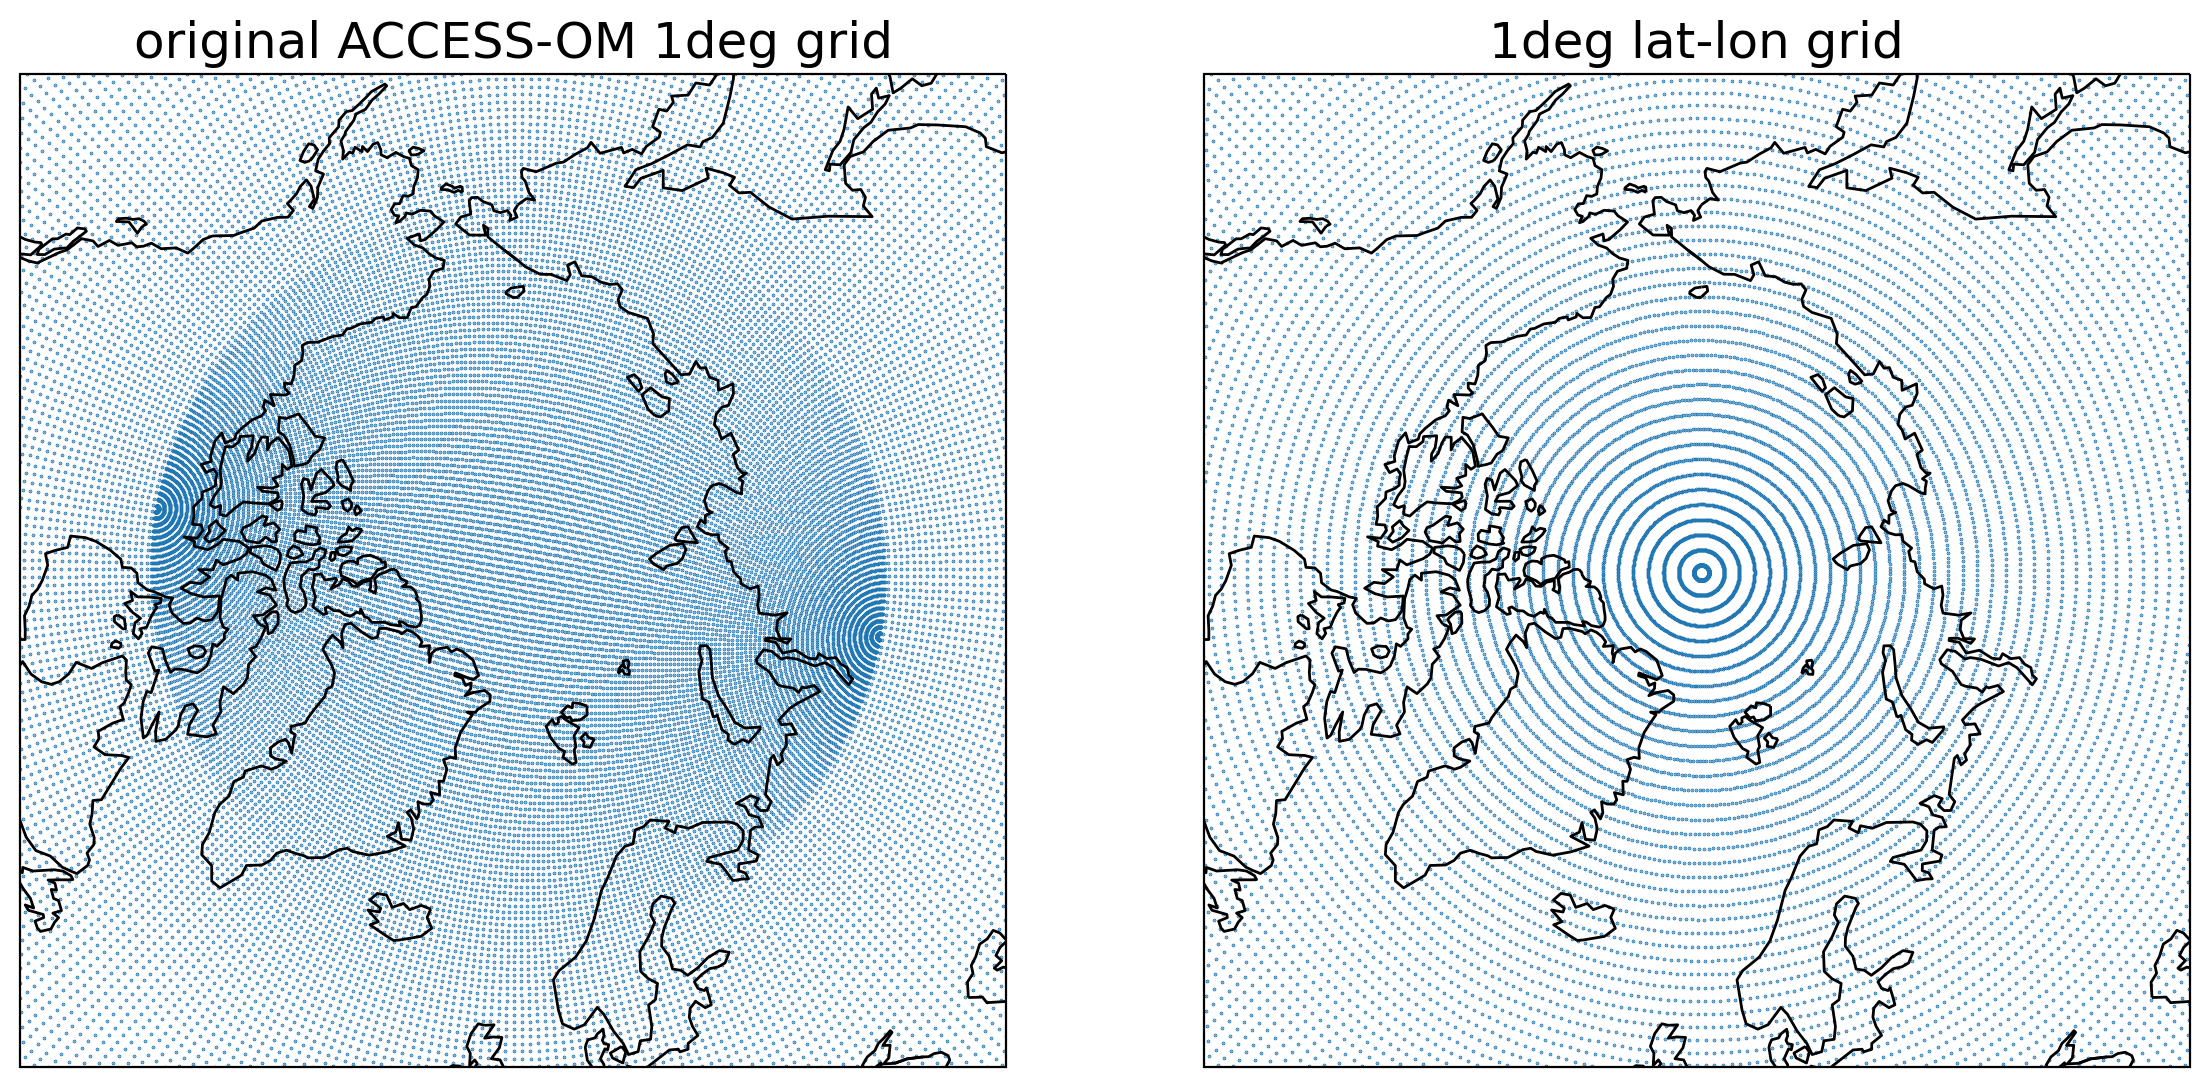

In [9]:
projection = ccrs.cartopy.crs.Orthographic(central_longitude=0.0, central_latitude=90)
fig, axes = plt.subplots(ncols = 2, subplot_kw={'projection': projection}, figsize = (14, 8))

axes[0].scatter(ssh_1['longitude'], ssh_1['latitude'], s=0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes[0].set_title('original ACCESS-OM 1deg grid', fontsize=18)

axes[1].scatter(ds_out['longitude'], ds_out['latitude'], s=0.1, transform=ccrs.PlateCarree())  # plot grid locations
axes[1].set_title('1deg lat-lon grid', fontsize=18);

for ax in axes:
    ax.coastlines()
    ax.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())

To regrid our fields we need to construct the three regridders for the three different resolutions using `xesmf.Regridder()`. The `xesmf.Regridder()` function takes as input two datasets, one that includes the original grid and one that includes the grids we need to regrid on. (Type `?xesmf.Regridder` for the function's docstring.) The coordinates' names have to follow CF-convetions and this is why we have renamed, e.g., `geolon_t` to `longitude`. 
We also make sure to drop the 1D coords `x` and `y` to **force** the regridder to use the 2D arrays `longitude` and `latitude`.

**Note**: The 0.10 degree `regridder_010degACCESSOM2_1deg` below should take ~3-4 minutes to compute.

In [10]:
%%time
ds_in_1deg = ssh_1.drop({'x', 'y'}).cf.to_dataset()

regridder_1degACCESSOM2_1deg = xesmf.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True,
                                               filename="bilinear_tracer_weights_in1degACCESSOM2_out1deg.nc")
regridder_1degACCESSOM2_1deg

CPU times: user 7.38 s, sys: 464 ms, total: 7.84 s
Wall time: 7.54 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in1degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (300, 360) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [11]:
%%time
ds_in_025deg = ssh_025.drop({'x', 'y'}).cf.to_dataset()

regridder_025degACCESSOM2_1deg = xesmf.Regridder(ds_in_025deg, ds_out, 'bilinear', periodic=True,
                                                 filename="bilinear_tracer_weights_in025degACCESSOM2_out1deg.nc")
regridder_025degACCESSOM2_1deg

CPU times: user 34.1 s, sys: 2.22 s, total: 36.3 s
Wall time: 33.7 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in025degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1080, 1440) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [12]:
%%time
ds_in_010deg = ssh_010.drop({'x', 'y'}).cf.to_dataset()

regridder_010degACCESSOM2_1deg = xesmf.Regridder(ds_in_010deg, ds_out, 'bilinear', periodic=True,
                                                 filename="bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc")
regridder_010degACCESSOM2_1deg

CPU times: user 2min 54s, sys: 11 s, total: 3min 5s
Wall time: 2min 53s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_tracer_weights_in010degACCESSOM2_out1deg.nc 
Reuse pre-computed weights? False 
Input grid shape:           (2700, 3600) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

#### Note

For large grids (e.g., to regrid from a 0.10$^\circ$ grid to a 0.20 $^\circ$), it might take a while to compute the re-grid weights. But, when you compute them once, you can construct a regridder using the already computed weights from a netCDF file by providing the `reuse_weights=True` argument, e.g.,

```python
regridder = xesmf.Regridder(dataset_in, dataset_out, 'bilinear', periodic=True, 
                            filename='weights_file.nc', reuse_weights=True)
```
or to automatically recalculate the weights file only if it doesn't already exist, do
```python
import os
regridder = xesmf.Regridder(dataset_in, dataset_out, 'bilinear', periodic=True, 
                            filename='weights_file.nc', reuse_weights=os.path.exists('weights_file.nc'))
```

## Let's regrid our output

Now we use the regridders we constructed above to regrid our output. Note that the dimensions we are applying the re-gridding can't be chunked, so we make sure we apply `.chunk({'x': -1, 'y': -1})` before giving the data arrays to the regridder. The `time` axis can be chunked --- for big datasets make sure that you rechunk `time` if needed so you don't end up with *huge* chunk sizes afte `.chunk({'x': -1, 'y': -1})` is applied.

Note also that for the regridded data arrays, we add back the longitude/latitude values on coords `x`/`y` respectively to make our lives easier with plotting later on.

In [13]:
%%time
ssh_1_regridded = regridder_1degACCESSOM2_1deg(ssh_1.chunk({'x': -1, 'y': -1}))
ssh_1_regridded = ssh_1_regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
ssh_1_regridded = ssh_1_regridded.rename({'x': 'longitude', 'y': 'latitude'})
ssh_1_regridded

CPU times: user 2.61 s, sys: 314 ms, total: 2.92 s
Wall time: 3.07 s


<xarray.DataArray (time: 24, latitude: 180, longitude: 360)>
dask.array<_regrid, shape=(24, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2000-01-14T12:00:00 ... 2001-12-14T12:00:00
  * longitude  (longitude) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

In [14]:
%%time
ssh_025_regridded = regridder_025degACCESSOM2_1deg(ssh_025.chunk({'x': -1, 'y': -1}))
ssh_025_regridded = ssh_025_regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
ssh_025_regridded = ssh_025_regridded.rename({'x': 'longitude', 'y': 'latitude'})
ssh_025_regridded

CPU times: user 46.4 ms, sys: 578 µs, total: 46.9 ms
Wall time: 41.3 ms


<xarray.DataArray (time: 24, latitude: 180, longitude: 360)>
dask.array<_regrid, shape=(24, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2000-01-14T12:00:00 ... 2001-12-14T12:00:00
  * longitude  (longitude) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

In [17]:
%%time
ssh_010_regridded = regridder_010degACCESSOM2_1deg(ssh_010.chunk({'x': -1, 'y': -1, 'time': 2}))
ssh_010_regridded = ssh_010_regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
ssh_010_regridded = ssh_010_regridded.rename({'x': 'longitude', 'y': 'latitude'})
ssh_010_regridded

CPU times: user 83.6 ms, sys: 753 µs, total: 84.3 ms
Wall time: 74.4 ms


<xarray.DataArray (time: 24, latitude: 180, longitude: 360)>
dask.array<_regrid, shape=(24, 180, 360), dtype=float32, chunksize=(2, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2001-12-16T12:00:00
  * longitude  (longitude) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

## Plotting time

Now we can plot the regridded fields, slicing as we like using `longitude` and `latitude` coordinates. Here's a comparisson of monthly-mean snapshots for sea-surface height in the North Pacific. Notice how things look "normal" north of 65$^\circ$N where the model's grid has the tripolar complications!

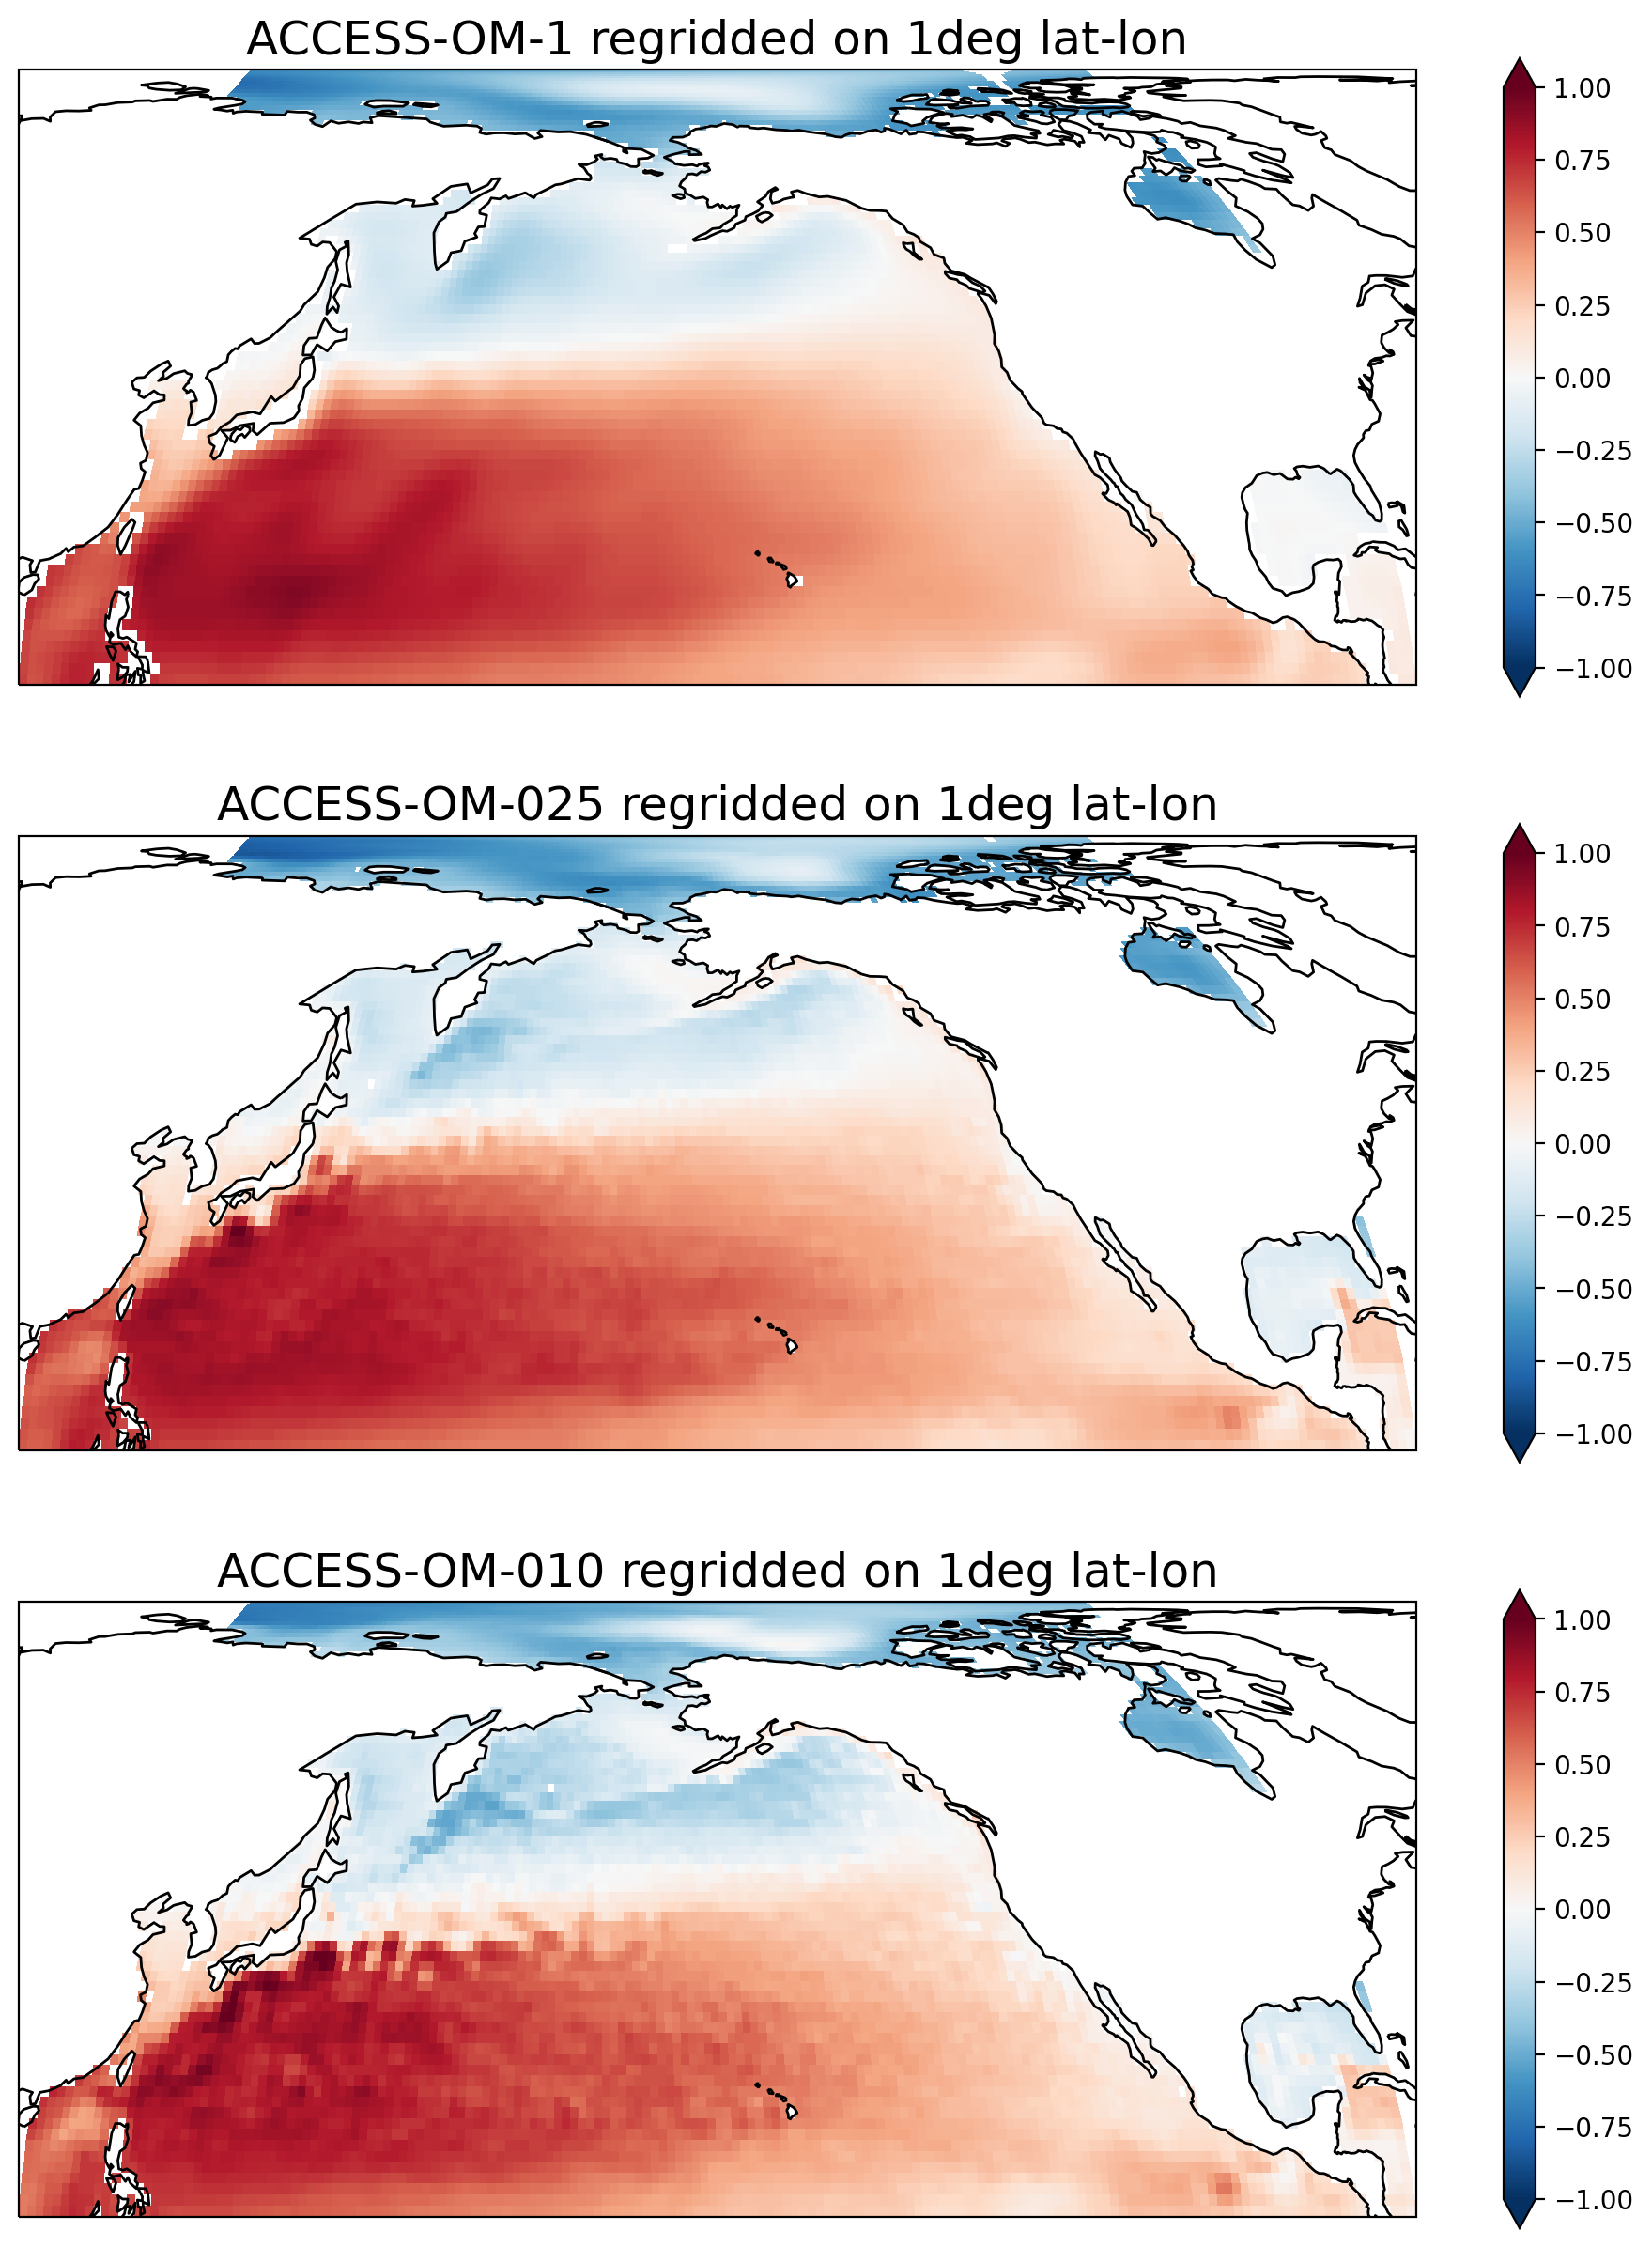

In [22]:
projection = ccrs.cartopy.crs.EqualEarth(central_longitude=180.0)

fig, axes = plt.subplots(nrows = 3, subplot_kw={'projection': projection}, figsize = (12, 15))

for ax in axes:
    ax.coastlines()

ssh_1_regridded.isel(time=0).sel({'longitude': slice(-250, -80),
                                  'latitude': slice(10, 90)}).plot(ax=axes[0], transform=ccrs.PlateCarree(),
                                                                   extend='both', vmin=-1, vmax=1, cmap='RdBu_r')
axes[0].set_title('ACCESS-OM-1 regridded on 1deg lat-lon', fontsize=18)

ssh_025_regridded.isel(time=0).sel({'longitude': slice(-250, -80),
                                    'latitude': slice(10, 90)}).plot(ax=axes[1], transform=ccrs.PlateCarree(),
                                                                     extend='both', vmin=-1, vmax=1, cmap='RdBu_r')

axes[1].set_title('ACCESS-OM-025 regridded on 1deg lat-lon', fontsize=18)


ssh_010_regridded.isel(time=0).sel({'longitude': slice(-250, -80),
                                    'latitude': slice(10, 90)}).plot(ax=axes[2], transform=ccrs.PlateCarree(),
                                                                     extend='both', vmin=-1, vmax=1, cmap='RdBu_r')

axes[2].set_title('ACCESS-OM-010 regridded on 1deg lat-lon', fontsize=18);

Another thing we can do now that we have everything on the same grid is to compute difference between fields from different model resolutions.

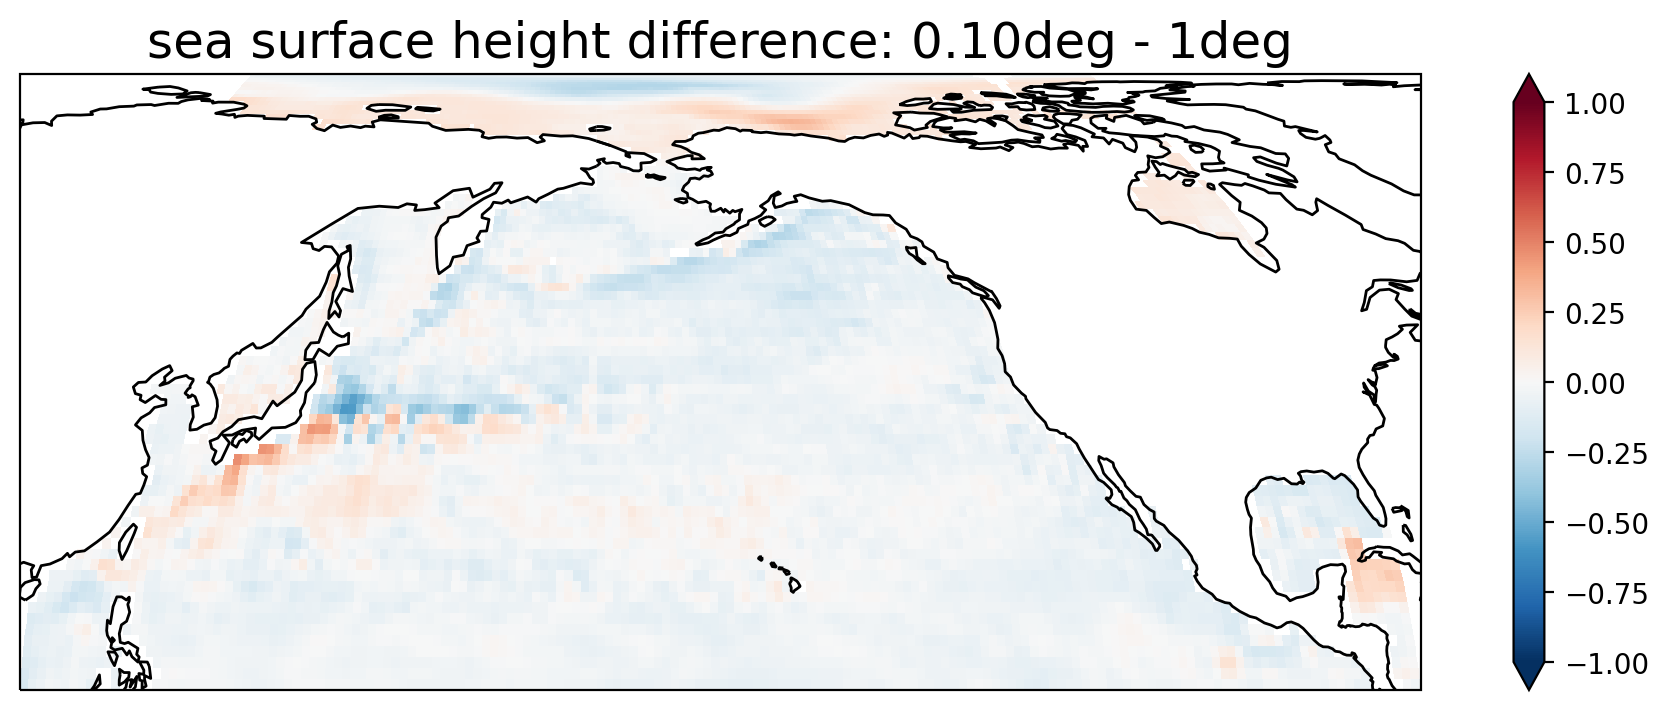

In [21]:
plt.figure(figsize=(12, 4))
ax = plt.axes(projection=ccrs.cartopy.crs.EqualEarth(central_longitude=180.0))

(ssh_010_regridded.isel(time=0) - ssh_1_regridded.isel(time=0)).sel(
    {'longitude': slice(-250, -80), 'latitude': slice(10, 90)}).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                                     extend='both', vmin=-1, vmax=1, cmap='RdBu_r')
ax.coastlines()
plt.title('sea surface height difference: 0.10deg - 1deg', fontsize=18);

## Further examples
The "Regridders" section [here](https://nbviewer.jupyter.org/github/aekiss/ice_analysis/blob/main/ice_maps.ipynb#Regridders) has examples of functions that generate functions to regrid between ACCESS-OM2 resolutions and from various other datasets (JRA55, GIOMAS and NSIDC) to the three ACCESS-OM2 resolutions. The regridder functions automatically save and reuse weights.